In [1]:
import pyibl
import random
#from random import random
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
from tqdm import tqdm

## No Cost Condition

No Probing Cost, Deception
Deception, Not Deception 15048 14952
Probe on regular webserver, honeypot webserver, no webserver 0.41901980179541254 0.42334969485451934 0.15763050335006812
Attack on regular webserver, honeypot webserver, no webserver 0.39253333333333335 0.4079 0.19956666666666667


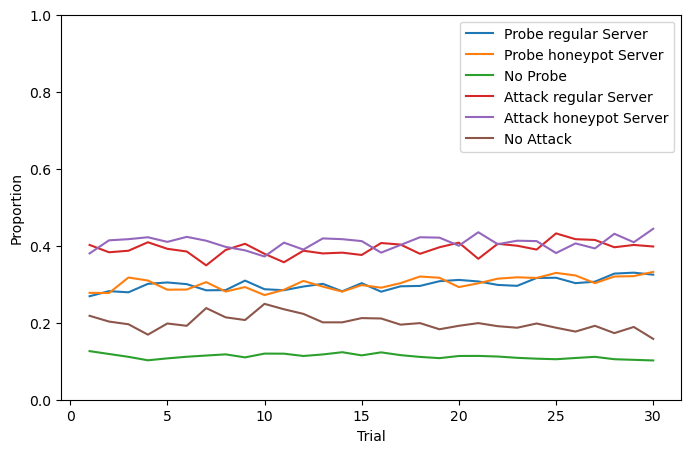

In [19]:
# No Cost: Deceptions

# Set global variables
PARTICIPANTS = 1000
DECAY = 0.5
NOISE = 0.25
TEMPERATURE = 1.0
#DEFAULT_OUTPUT_FILE = "box-data_Signaling.csv"
TARGET_COUNT = 2
TRIALS = 30
def reset_agent(agent, noise=NOISE, temperature=TEMPERATURE, decay=DECAY):
    agent.reset(False)
    agent.noise = noise
    agent.decay = decay
    agent.temperature = temperature
def run():
    agent = pyibl.Agent("Agent", ["action", "warning"], optimized_learning=False)
    #attack_agent = pyibl.Agent("Attack Agent", ["attack"], optimized_learning=False)
    with open('No_Cost.csv', "w") as f:
        print("Subject,Trial,Action,Covered1,Covered2,Warning,Outcome", file=f)
        probe_rs = 0
        probe_hs = 0
        probe_no = 0
        attack_rs = 0
        attack_hs = 0
        attack_no = 0
        total_probe = 0
        d_c = 0
        p_rs = [0] * TRIALS
        p_hs = [0] * TRIALS
        p_no = [0] * TRIALS
        a_rs = [0] * TRIALS
        a_hs = [0] * TRIALS
        a_no = [0] * TRIALS
        for p in range(PARTICIPANTS):

            total = 0
            reset_agent(agent)    

            agent.populate(50, {"action": -1, "warning":2})
            agent.populate(50, {"action": 0, "warning":2})
            agent.populate(50, {"action": 1, "warning":2})
            agent.populate(50, {"action": 2, "warning":2})
            agent.populate(50, {"action": 3, "warning":2})

            agent.populate(50, {"action": -1, "warning":0})
            agent.populate(50, {"action": 0, "warning":0})
            agent.populate(50, {"action": 1, "warning":0})
            agent.populate(50, {"action": 2, "warning":0})
            agent.populate(50, {"action": 3, "warning":0})

            agent.populate(50, {"action": -1, "warning":1})
            agent.populate(50, {"action": 0, "warning":1})
            agent.populate(50, {"action": 1, "warning":1})
            agent.populate(50, {"action": 2, "warning":1})
            agent.populate(50, {"action": 3, "warning":1})


            for t in range(TRIALS):
                COVERAGE1 = np.random.choice([0,1,2,3], size=(1,), p=[.25,.25,.25,.25])[0]
                COVERAGE2 = np.random.choice([0,1,2,3], size=(1,), p=[.25,.25,.25,.25])[0]
                deception = np.random.choice([0,1], size=(1,), p=[.5,.5])[0]
                if deception:
                    d_c += 1
                while COVERAGE1 == COVERAGE2:
                    COVERAGE2 = np.random.choice([0,1,2,3], size=(1,), p=[.25,.25,.25,.25])[0]
                i = 1
                #print('Cov ', COVERAGE1, COVERAGE2)
                #probe = True
                respond_list = [0]*5
                payoff_list = [0]*5
                prev = True
                while i <= 5:
                    #print('pti', p, t, i)
                    total_probe += 1
                    payoff = 0
                    #print('i ',i)
                    #w =[0,0,0,0]
                    #warned = np.random.choice([0,1], size=(1,), p=[.5,.5])[0]  # Signal
                    sig = 0 
                    if deception == 1:
                        sig = 1 if prev == False else 0
                    else:
                        sig = 0 if prev == False else 1
                    if i == 1:
                        sig = 2
                    selected = agent.choose({"action": -1, "warning": sig}, 
                                                {"action": 0, "warning": sig}, 
                                                {"action": 1, "warning": sig},
                                                {"action": 2, "warning": sig}, 
                                                {"action": 3, "warning": sig})['action']

                    prev = (selected == COVERAGE1) or (selected == COVERAGE2) 

                    #print('sel ', selected, sig)

                    if selected == -1:
                        payoff = 0
                        probe_no += 1
                        p_no[t] += 1
                        r = agent.respond()
                        respond_list[i - 1] = r
                        payoff_list[i - 1] = payoff
                        i += 1
                        print(f"{p+1},{t+1},{selected}, {int(COVERAGE1)},{int(COVERAGE2)}, {int(sig)},{payoff}",file = f)
                        break
                    elif selected == COVERAGE1 or selected == COVERAGE2:
                        #payoff += -5
                        payoff = 0
                        probe_hs += 1
                        p_hs[t] += 1

                    else:
                        payoff = 5
                        probe_rs += 1
                        p_rs[t] += 1
                    #if i != 5:
                    #    selection_agent.respond(payoff)
                    r = agent.respond()
                    respond_list[i - 1] = r
                    payoff_list[i - 1] = payoff

                    i += 1

                    print(f"{p+1},{t+1},{selected}, {int(COVERAGE1)},{int(COVERAGE2)}, {int(sig)},{payoff}",file = f)

                    #print(agent.instances())

                payoff = 0

                #print('i ', i)

                sig = 0 
                if deception == 1:
                    sig = 1 if prev == False else 0
                else:
                    sig = 0 if prev == False else 1

                attack = agent.choose({"action": -1, "warning": sig}, 
                                        {"action": 0, "warning": sig}, 
                                        {"action": 1, "warning": sig},
                                        {"action": 2, "warning": sig}, 
                                        {"action": 3, "warning": sig})['action']

                #print('attack ', attack, sig)

                if attack == -1:
                    payoff = 0
                    attack_no += 1
                    a_no[t] += 1
                elif attack == COVERAGE1 or attack == COVERAGE2:
                    payoff = -10
                    attack_hs += 1
                    a_hs[t] += 1
                else:
                    payoff = 10
                    attack_rs += 1
                    a_rs[t] += 1
                #total += payoff
                agent.respond(payoff)
                #print(agent.instances())
                for j in range(0,i - 1):
                    r = respond_list[j]
                    r.update(payoff_list[j])
                #print(agent.instances())
                #selection_agent.respond(payoff)
                print(f"{p+1},{t+1},{selected}, {int(COVERAGE1)},{int(COVERAGE2)}, {int(sig)},{payoff}",file = f)
                #print(f"{p+1},{t+1},{selected},{int(warned)},{int(covered)},{int(attack)},{payoff}",file = f)
        print('Deception, Not Deception', d_c, (TRIALS * PARTICIPANTS) - d_c)
        
        print('Probe on regular webserver, honeypot webserver, no webserver', probe_rs / total_probe, 
              probe_hs / total_probe, probe_no / total_probe)
        print('Attack on regular webserver, honeypot webserver, no webserver', attack_rs / (TRIALS * PARTICIPANTS), 
              attack_hs / (TRIALS * PARTICIPANTS), attack_no / (TRIALS * PARTICIPANTS))
        #return [attack_failed / (TRIALS * PARTICIPANTS), attack_successful / (TRIALS * PARTICIPANTS), attack_withdraw / (TRIALS * PARTICIPANTS)]
        return [[n / (PARTICIPANTS * 5) for n in p_rs], [n / (PARTICIPANTS * 5) for n in p_hs], [n / (PARTICIPANTS * 5) for n in p_no],
            [n / PARTICIPANTS for n in a_rs], [n / PARTICIPANTS for n in a_hs], [n / PARTICIPANTS for n in a_no] ]

if __name__ == '__main__':
    print('No Probing Cost, Deception')
    a = run()
    fig = plt.figure(figsize =(8, 5))
    
    plt.plot(range(1, TRIALS + 1), a[0], label = 'Probe regular Server')
    plt.plot(range(1, TRIALS + 1), a[1], label = 'Probe honeypot Server')
    plt.plot(range(1, TRIALS + 1), a[2], label = 'No Probe')
    plt.plot(range(1, TRIALS + 1), a[3], label = 'Attack regular Server')
    plt.plot(range(1, TRIALS + 1), a[4], label = 'Attack honeypot Server')
    plt.plot(range(1, TRIALS + 1), a[5], label = 'No Attack')
    plt.ylim([0, 1])
    plt.ylabel("Proportion")
    plt.xlabel("Trial")
    plt.legend()
    plt.show()
    
    #print("attack on covered box, attacks on uncovered box, withdraw action",a[0], a[1], a[2])

## Constant Cost Condition

Constant Probing Cost, Deception
Deception, Not Deception 14984 15016
Probe on regular webserver, honeypot webserver, no webserver 0.41223066554667814 0.408157683967885 0.1796116504854369
Attack on regular webserver, honeypot webserver, no webserver 0.37943333333333334 0.3975666666666667 0.223


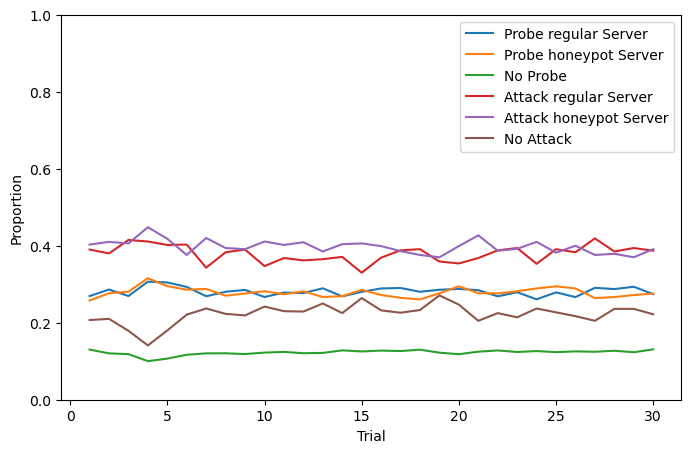

In [20]:
# Constant Cost: Deceptions

# Set global variables
PARTICIPANTS = 1000
DECAY = 0.5
NOISE = 0.25
TEMPERATURE = 1.0
#DEFAULT_OUTPUT_FILE = "box-data_Signaling.csv"
TARGET_COUNT = 2
TRIALS = 30
def reset_agent(agent, noise=NOISE, temperature=TEMPERATURE, decay=DECAY):
    agent.reset(False)
    agent.noise = noise
    agent.decay = decay
    agent.temperature = temperature
def run():
    agent = pyibl.Agent("Agent", ["action", "warning"], optimized_learning=False)
    #attack_agent = pyibl.Agent("Attack Agent", ["attack"], optimized_learning=False)
    with open('Constant_Cost.csv', "w") as f:
        print("Subject,Trial,Action,Covered1,Covered2,Warning,Outcome", file=f)
        probe_rs = 0
        probe_hs = 0
        probe_no = 0
        attack_rs = 0
        attack_hs = 0
        attack_no = 0
        total_probe = 0
        d_c = 0
        p_rs = [0] * TRIALS
        p_hs = [0] * TRIALS
        p_no = [0] * TRIALS
        a_rs = [0] * TRIALS
        a_hs = [0] * TRIALS
        a_no = [0] * TRIALS
        for p in range(PARTICIPANTS):
            total = 0
            reset_agent(agent)
            #reset_agent(attack_agent)
            # Populate instances for t=0

            agent.populate(50, {"action": -1, "warning":2})
            agent.populate(50, {"action": 0, "warning":2})
            agent.populate(50, {"action": 1, "warning":2})
            agent.populate(50, {"action": 2, "warning":2})
            agent.populate(50, {"action": 3, "warning":2})

            agent.populate(50, {"action": -1, "warning":0})
            agent.populate(50, {"action": 0, "warning":0})
            agent.populate(50, {"action": 1, "warning":0})
            agent.populate(50, {"action": 2, "warning":0})
            agent.populate(50, {"action": 3, "warning":0})

            agent.populate(50, {"action": -1, "warning":1})
            agent.populate(50, {"action": 0, "warning":1})
            agent.populate(50, {"action": 1, "warning":1})
            agent.populate(50, {"action": 2, "warning":1})
            agent.populate(50, {"action": 3, "warning":1})


            for t in range(TRIALS):
                COVERAGE1 = np.random.choice([0,1,2,3], size=(1,), p=[.25,.25,.25,.25])[0]
                COVERAGE2 = np.random.choice([0,1,2,3], size=(1,), p=[.25,.25,.25,.25])[0]
                deception = np.random.choice([0,1], size=(1,), p=[.5,.5])[0]
                if deception:
                    d_c += 1
                while COVERAGE1 == COVERAGE2:
                    COVERAGE2 = np.random.choice([0,1,2,3], size=(1,), p=[.25,.25,.25,.25])[0]
                i = 1
                #print('Cov ', COVERAGE1, COVERAGE2)
                #probe = True
                respond_list = [0]*5
                payoff_list = [0]*5
                prev = True
                while i <= 5:
                    #print('pti', p, t, i)
                    total_probe += 1
                    payoff = 0
                    #print('i ',i)
                    #w =[0,0,0,0]
                    #warned = np.random.choice([0,1], size=(1,), p=[.5,.5])[0]  # Signal
                    sig = 0 
                    if deception == 1:
                        sig = 1 if prev == False else 0
                    else:
                        sig = 0 if prev == False else 1
                    if i == 1:
                        sig = 2
                    selected = agent.choose({"action": -1, "warning": sig}, 
                                            {"action": 0, "warning": sig}, 
                                            {"action": 1, "warning": sig},
                                            {"action": 2, "warning": sig}, 
                                            {"action": 3, "warning": sig})['action']

                    prev = (selected == COVERAGE1) or (selected == COVERAGE2) 

                    #print('sel ', selected, sig)

                    if selected == -1:
                        payoff = 0
                        probe_no += 1
                        p_no[t] += 1
                        r = agent.respond()
                        respond_list[i - 1] = r
                        payoff_list[i - 1] = payoff
                        i += 1
                        print(f"{p+1},{t+1},{selected}, {int(COVERAGE1)},{int(COVERAGE2)}, {int(sig)},{payoff}",file = f)
                        break
                    elif selected == COVERAGE1 or selected == COVERAGE2:
                        #payoff += -5
                        payoff = -5
                        probe_hs += 1
                        p_hs[t] += 1

                    else:
                        payoff = 5
                        probe_rs += 1
                        p_rs[t] += 1
                    #if i != 5:
                    #    selection_agent.respond(payoff)
                    r = agent.respond()
                    respond_list[i - 1] = r
                    payoff_list[i - 1] = payoff

                    i += 1

                    print(f"{p+1},{t+1},{selected}, {int(COVERAGE1)},{int(COVERAGE2)}, {int(sig)},{payoff}",file = f)

                    #print(agent.instances())

                payoff = 0

                #print('i ', i)

                sig = 0 
                if deception == 1:
                    sig = 1 if prev == False else 0
                else:
                    sig = 0 if prev == False else 1

                attack = agent.choose({"action": -1, "warning": sig}, 
                                        {"action": 0, "warning": sig}, 
                                        {"action": 1, "warning": sig},
                                        {"action": 2, "warning": sig}, 
                                        {"action": 3, "warning": sig})['action']

                #print('attack ', attack, sig)

                if attack == -1:
                    payoff = 0
                    attack_no += 1
                    a_no[t] += 1
                elif attack == COVERAGE1 or attack == COVERAGE2:
                    payoff = -10
                    attack_hs += 1
                    a_hs[t] += 1
                else:
                    payoff = 10
                    attack_rs += 1
                    a_rs[t] += 1
                #total += payoff
                agent.respond(payoff)
                #print(agent.instances())
                for j in range(0,i - 1):
                    r = respond_list[j]
                    r.update(payoff_list[j])
                #print(agent.instances())
                #selection_agent.respond(payoff)
                print(f"{p+1},{t+1},{selected}, {int(COVERAGE1)},{int(COVERAGE2)}, {int(sig)},{payoff}",file = f)
                #print(f"{p+1},{t+1},{selected},{int(warned)},{int(covered)},{int(attack)},{payoff}",file = f)
    print('Deception, Not Deception', d_c, (TRIALS * PARTICIPANTS) - d_c)
    print('Probe on regular webserver, honeypot webserver, no webserver', probe_rs / total_probe, 
          probe_hs / total_probe, probe_no / total_probe)
    print('Attack on regular webserver, honeypot webserver, no webserver', attack_rs / (TRIALS * PARTICIPANTS), 
          attack_hs / (TRIALS * PARTICIPANTS), attack_no / (TRIALS * PARTICIPANTS))
    #return [attack_failed / (TRIALS * PARTICIPANTS), attack_successful / (TRIALS * PARTICIPANTS), attack_withdraw / (TRIALS * PARTICIPANTS)]
    return [[n / (PARTICIPANTS * 5) for n in p_rs], [n / (PARTICIPANTS * 5) for n in p_hs], [n / (PARTICIPANTS * 5) for n in p_no],
            [n / PARTICIPANTS for n in a_rs], [n / PARTICIPANTS for n in a_hs], [n / PARTICIPANTS for n in a_no] ]

    
if __name__ == '__main__':
    print('Constant Probing Cost, Deception')
    a = run()
    fig = plt.figure(figsize =(8, 5))
    
    plt.plot(range(1, TRIALS + 1), a[0], label = 'Probe regular Server')
    plt.plot(range(1, TRIALS + 1), a[1], label = 'Probe honeypot Server')
    plt.plot(range(1, TRIALS + 1), a[2], label = 'No Probe')
    plt.plot(range(1, TRIALS + 1), a[3], label = 'Attack regular Server')
    plt.plot(range(1, TRIALS + 1), a[4], label = 'Attack honeypot Server')
    plt.plot(range(1, TRIALS + 1), a[5], label = 'No Attack')
    plt.ylim([0, 1])
    plt.ylabel("Proportion")
    plt.xlabel("Trial")
    plt.legend()
    plt.show()
    
    #print("attack on covered box, attacks on uncovered box, withdraw action",a[0], a[1], a[2])

## Increasing Cost Condition

Increasing Probing Cost, Deception
Deception, Not Deception 14957 15043
Probe on regular webserver, honeypot webserver, no webserver 0.39743393920879794 0.39946031261137416 0.2031057481798279
Attack on regular webserver, honeypot webserver, no webserver 0.3574 0.3781333333333333 0.2644666666666667


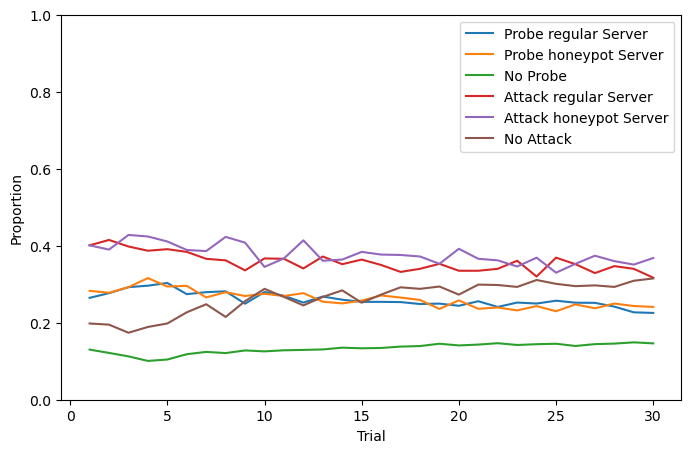

In [21]:
# Increasing Cost: Deceptions

# Set global variables
PARTICIPANTS = 1000
DECAY = 0.5
NOISE = 0.25
TEMPERATURE = 1.0
#DEFAULT_OUTPUT_FILE = "box-data_Signaling.csv"
TARGET_COUNT = 2
TRIALS = 30
def reset_agent(agent, noise=NOISE, temperature=TEMPERATURE, decay=DECAY):
    agent.reset(False)
    agent.noise = noise
    agent.decay = decay
    agent.temperature = temperature
def run():
    agent = pyibl.Agent("Agent", ["action", "warning"], optimized_learning=False)
    #attack_agent = pyibl.Agent("Attack Agent", ["attack"], optimized_learning=False)
    with open('Increasing_Cost.csv', "w") as f:
        print("Subject,Trial,Action,Covered1,Covered2,Warning,Outcome", file=f)
   # with open(output_file, "w") as f:
        #print("Subject,Trial,Selected,Warning,Covered,Action,Outcome", file=f)
        probe_rs = 0
        probe_hs = 0
        probe_no = 0
        attack_rs = 0
        attack_hs = 0
        attack_no = 0
        total_probe = 0
        d_c = 0
        p_rs = [0] * TRIALS
        p_hs = [0] * TRIALS
        p_no = [0] * TRIALS
        a_rs = [0] * TRIALS
        a_hs = [0] * TRIALS
        a_no = [0] * TRIALS
        for p in range(PARTICIPANTS):


            total = 0
            reset_agent(agent)
            #reset_agent(attack_agent)
            # Populate instances for t=0

            agent.populate(50, {"action": -1, "warning":2})
            agent.populate(50, {"action": 0, "warning":2})
            agent.populate(50, {"action": 1, "warning":2})
            agent.populate(50, {"action": 2, "warning":2})
            agent.populate(50, {"action": 3, "warning":2})

            agent.populate(50, {"action": -1, "warning":0})
            agent.populate(50, {"action": 0, "warning":0})
            agent.populate(50, {"action": 1, "warning":0})
            agent.populate(50, {"action": 2, "warning":0})
            agent.populate(50, {"action": 3, "warning":0})

            agent.populate(50, {"action": -1, "warning":1})
            agent.populate(50, {"action": 0, "warning":1})
            agent.populate(50, {"action": 1, "warning":1})
            agent.populate(50, {"action": 2, "warning":1})
            agent.populate(50, {"action": 3, "warning":1})


            for t in range(TRIALS):
                COVERAGE1 = np.random.choice([0,1,2,3], size=(1,), p=[.25,.25,.25,.25])[0]
                COVERAGE2 = np.random.choice([0,1,2,3], size=(1,), p=[.25,.25,.25,.25])[0]
                deception = np.random.choice([0,1], size=(1,), p=[.5,.5])[0]
                if deception:
                    d_c += 1
                while COVERAGE1 == COVERAGE2:
                    COVERAGE2 = np.random.choice([0,1,2,3], size=(1,), p=[.25,.25,.25,.25])[0]
                i = 1
                j = 1
                #print('Cov ', COVERAGE1, COVERAGE2)
                #probe = True
                respond_list = [0]*5
                payoff_list = [0]*5
                prev = True
                while i <= 5:
                    #print('pti', p, t, i)
                    total_probe += 1
                    payoff = 0
                    #print('i ',i)
                    #w =[0,0,0,0]
                    #warned = np.random.choice([0,1], size=(1,), p=[.5,.5])[0]  # Signal
                    sig = 0 
                    if deception == 1:
                        sig = 1 if prev == False else 0
                    else:
                        sig = 0 if prev == False else 1
                    if i == 1:
                        sig = 2
                    selected = agent.choose({"action": -1, "warning": sig}, 
                                            {"action": 0, "warning": sig}, 
                                            {"action": 1, "warning": sig},
                                            {"action": 2, "warning": sig}, 
                                            {"action": 3, "warning": sig})['action']

                    prev = (selected == COVERAGE1) or (selected == COVERAGE2) 

                    #print('sel ', selected, sig)

                    if selected == -1:
                        payoff = 0
                        probe_no += 1
                        p_no[t] += 1
                        r = agent.respond()
                        respond_list[i - 1] = r
                        payoff_list[i - 1] = payoff
                        i += 1
                        print(f"{p+1},{t+1},{selected}, {int(COVERAGE1)},{int(COVERAGE2)}, {int(sig)},{payoff}",file = f)
                        break
                    elif selected == COVERAGE1 or selected == COVERAGE2:
                        #payoff += -5
                        payoff = -5 * j
                        j = j + 1
                        probe_hs += 1
                        p_hs[t] += 1

                    else:
                        payoff = 5
                        probe_rs += 1
                        p_rs[t] += 1
                    #if i != 5:
                    #    selection_agent.respond(payoff)
                    r = agent.respond()
                    respond_list[i - 1] = r
                    payoff_list[i - 1] = payoff

                    i += 1
                    print(f"{p+1},{t+1},{selected}, {int(COVERAGE1)},{int(COVERAGE2)}, {int(sig)},{payoff}",file = f)

                    #print(agent.instances())

                payoff = 0

                #print('i ', i)

                sig = 0 
                if deception == 1:
                    sig = 1 if prev == False else 0
                else:
                    sig = 0 if prev == False else 1

                attack = agent.choose({"action": -1, "warning": sig}, 
                                        {"action": 0, "warning": sig}, 
                                        {"action": 1, "warning": sig},
                                        {"action": 2, "warning": sig}, 
                                        {"action": 3, "warning": sig})['action']
                #print('attack ', attack, sig)

                if attack == -1:
                    payoff = 0
                    attack_no += 1
                    a_no[t] += 1
                elif attack == COVERAGE1 or attack == COVERAGE2:
                    payoff = -10
                    attack_hs += 1
                    a_hs[t] += 1
                else:
                    payoff = 10
                    attack_rs += 1
                    a_rs[t] += 1
                #total += payoff
                agent.respond(payoff)
                #print(agent.instances())
                for j in range(0,i - 1):
                    r = respond_list[j]
                    r.update(payoff_list[j])
                #print(agent.instances())
                #selection_agent.respond(payoff)
                print(f"{p+1},{t+1},{selected}, {int(COVERAGE1)},{int(COVERAGE2)}, {int(sig)},{payoff}",file = f)
            #print(f"{p+1},{t+1},{selected},{int(warned)},{int(covered)},{int(attack)},{payoff}",file = f)
    print('Deception, Not Deception', d_c, (TRIALS * PARTICIPANTS) - d_c)
    print('Probe on regular webserver, honeypot webserver, no webserver', probe_rs / total_probe, 
          probe_hs / total_probe, probe_no / total_probe)
    print('Attack on regular webserver, honeypot webserver, no webserver', attack_rs / (TRIALS * PARTICIPANTS), 
          attack_hs / (TRIALS * PARTICIPANTS), attack_no / (TRIALS * PARTICIPANTS))
    #return [attack_failed / (TRIALS * PARTICIPANTS), attack_successful / (TRIALS * PARTICIPANTS), attack_withdraw / (TRIALS * PARTICIPANTS)]
    return [[n / (PARTICIPANTS * 5) for n in p_rs], [n / (PARTICIPANTS * 5) for n in p_hs], [n / (PARTICIPANTS * 5) for n in p_no],
            [n / PARTICIPANTS for n in a_rs], [n / PARTICIPANTS for n in a_hs], [n / PARTICIPANTS for n in a_no] ]

    

if __name__ == '__main__':
    print('Increasing Probing Cost, Deception')
    a = run()
    fig = plt.figure(figsize =(8, 5))
    
    plt.plot(range(1, TRIALS + 1), a[0], label = 'Probe regular Server')
    plt.plot(range(1, TRIALS + 1), a[1], label = 'Probe honeypot Server')
    plt.plot(range(1, TRIALS + 1), a[2], label = 'No Probe')
    plt.plot(range(1, TRIALS + 1), a[3], label = 'Attack regular Server')
    plt.plot(range(1, TRIALS + 1), a[4], label = 'Attack honeypot Server')
    plt.plot(range(1, TRIALS + 1), a[5], label = 'No Attack')
    plt.ylim([0, 1])
    plt.ylabel("Proportion")
    plt.xlabel("Trial")
    plt.legend()
    plt.show()
    #print("attack on covered box, attacks on uncovered box, withdraw action",a[0], a[1], a[2])

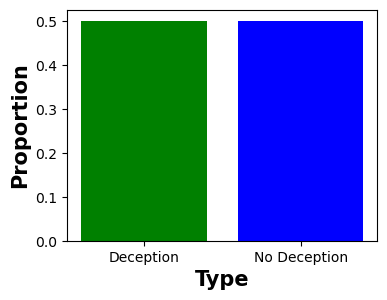

In [42]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize =(4, 3))
#ax = fig.add_axes([0,0,1,1])
Attack = ['Deception', 'No Deception']
Probability = [0.50083, 0.499167]
plt.bar(Attack,Probability, color =['g', 'b'])
plt.xlabel('Type',fontweight ='bold', fontsize = 15)
plt.ylabel('Proportion', fontweight ='bold', fontsize = 15)
plt.show()

## Barplot for both Probe and Attack

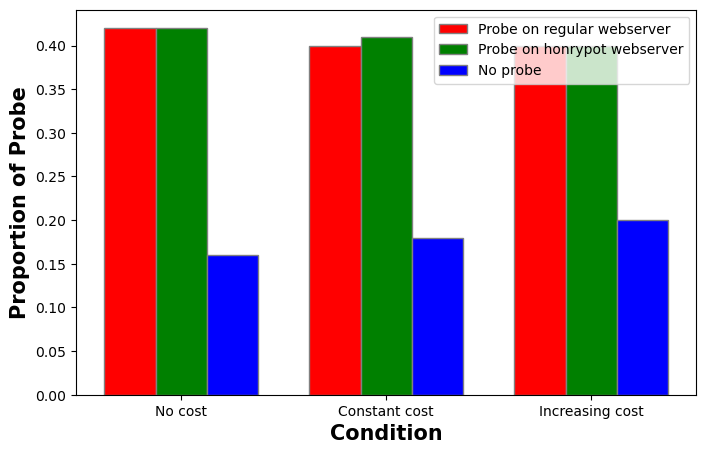

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# set width of bar
barWidth = 0.25
fig = plt.figure(figsize =(8, 5))

# set height of bar

cb = [0.42, 0.40, 0.40]
ucb = [0.42, 0.41, 0.40]
wa = [0.16, 0.18, 0.20]


# Set position of bar on X axis
br1 = np.arange(len(cb))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

# Make the plot
plt.bar(br1, cb, color ='r', width = barWidth, edgecolor ='grey', label ='Probe on regular webserver')
plt.bar(br2, ucb, color ='g', width = barWidth, edgecolor ='grey', label ='Probe on honrypot webserver')
plt.bar(br3, wa, color ='b', width = barWidth, edgecolor ='grey', label ='No probe')

# Adding Xticks
plt.xlabel('Condition', fontweight ='bold', fontsize = 15)
plt.ylabel('Proportion of Probe', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(cb))],['No cost', 'Constant cost', 'Increasing cost'])

plt.legend()
plt.show()


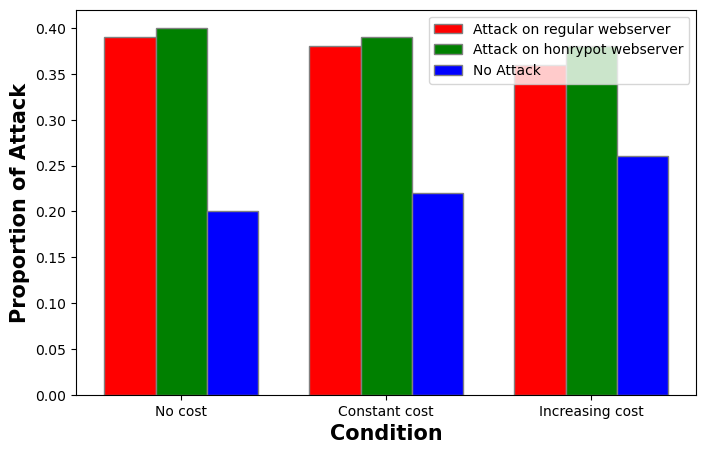

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# set width of bar
barWidth = 0.25
fig = plt.figure(figsize =(8, 5))

# set height of bar

cb = [0.39, 0.38, 0.36]
ucb = [0.40, 0.39, 0.38]
wa = [0.20, 0.22, 0.26]


# Set position of bar on X axis
br1 = np.arange(len(cb))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

# Make the plot
plt.bar(br1, cb, color ='r', width = barWidth, edgecolor ='grey', label ='Attack on regular webserver')
plt.bar(br2, ucb, color ='g', width = barWidth, edgecolor ='grey', label ='Attack on honrypot webserver')
plt.bar(br3, wa, color ='b', width = barWidth, edgecolor ='grey', label ='No Attack')

# Adding Xticks
plt.xlabel('Condition', fontweight ='bold', fontsize = 15)
plt.ylabel('Proportion of Attack', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(cb))],['No cost', 'Constant cost', 'Increasing cost'])

plt.legend()
plt.show()


## Data Analysis : No Cost

In [ ]:
import pip
pip.main(["install", "openpyxl"])

In [36]:
import pandas as pd

df1 = pd.read_excel('NoCost.xlsx', sheet_name='Probe')
df2 = pd.read_excel('NoCost.xlsx', sheet_name='Attack')
df3 = pd.read_excel('NoCost.xlsx', sheet_name='Honeypot')

0

In [37]:
len(df1), len(df2), len(df3)

(7030, 1131, 1131)

In [38]:
j = 0

probe_no = 0
probe_regular = 0
probe_honeypot = 0

for i in range(len(df3)):
    while j < len(df1) and df3['TrialNumber'][i] == df1['TrialNumber'][j] :
        if df1['ProbeChoice'][j] == 0:
            probe_no += 1
        elif df1['ProbeChoice'][j] == df3['HoneypotServer1'][i] or df1['ProbeChoice'][j] == df3['HoneypotServer2'][i]:
            probe_honeypot += 1
        else:
            probe_regular += 1
        j += 1
    
print('probe_no, probe_regular, probe_honeypot',probe_no / len(df1), probe_regular / len(df1), probe_honeypot / len(df1))
    
    

probe_no, probe_regular, probe_honeypot 0.0 0.5105263157894737 0.48947368421052634


In [39]:
j = 0

attack_no = 0
attack_regular = 0
attack_honeypot = 0

for i in range(len(df3)):
    while j < len(df2) and df3['TrialNumber'][i] == df2['TrialNumber'][j] :
        if df2['AttackChoice'][j] == 0:
            attack_no += 1
        elif df2['AttackChoice'][j] == df3['HoneypotServer1'][i] or df2['AttackChoice'][j] == df3['HoneypotServer2'][i]:
            attack_honeypot += 1
        else:
            attack_regular += 1
        j += 1
    
print('attack_no, attack_regular, attack_honeypot',attack_no / len(df2), attack_regular /  len(df2), attack_honeypot / len(df2))




attack_no, attack_regular, attack_honeypot 0.10786914235190097 0.4465075154730327 0.44562334217506633


## Data Analysis : Constant Cost

In [40]:
df1 = pd.read_excel('ConstantCost.xlsx', sheet_name='Probe')
df2 = pd.read_excel('ConstantCost.xlsx', sheet_name='Attack')
df3 = pd.read_excel('ConstantCost.xlsx', sheet_name='Honeypot')

In [41]:
len(df1), len(df2), len(df3)

(5810, 1160, 1160)

In [42]:
j = 0

probe_no = 0
probe_regular = 0
probe_honeypot = 0

for i in range(len(df3)):
    while j < len(df1) and df3['TrialNumber'][i] == df1['TrialNumber'][j] :
        if df1['ProbeChoice'][j] == 0:
            probe_no += 1
        elif df1['ProbeChoice'][j] == df3['HoneypotServer1'][i] or df1['ProbeChoice'][j] == df3['HoneypotServer2'][i]:
            probe_honeypot += 1
        else:
            probe_regular += 1
        j += 1
    
print('probe_no, probe_regular, probe_honeypot',probe_no / len(df1), probe_regular / len(df1), probe_honeypot / len(df1))



probe_no, probe_regular, probe_honeypot 0.0 0.48881239242685026 0.5111876075731497


In [43]:
j = 0

attack_no = 0
attack_regular = 0
attack_honeypot = 0

for i in range(len(df3)):
    while j < len(df2) and df3['TrialNumber'][i] == df2['TrialNumber'][j] :
        if df2['AttackChoice'][j] == 0:
            attack_no += 1
        elif df2['AttackChoice'][j] == df3['HoneypotServer1'][i] or df2['AttackChoice'][j] == df3['HoneypotServer2'][i]:
            attack_honeypot += 1
        else:
            attack_regular += 1
        j += 1
    
print('attack_no, attack_regular, attack_honeypot',attack_no / len(df2), attack_regular /  len(df2), attack_honeypot / len(df2))




attack_no, attack_regular, attack_honeypot 0.14396551724137932 0.421551724137931 0.43448275862068964


## Data Analysis : Increasing Cost

In [44]:
df1 = pd.read_excel('IncreasingCost.xlsx', sheet_name='Probe')
df2 = pd.read_excel('IncreasingCost.xlsx', sheet_name='Attack')
df3 = pd.read_excel('IncreasingCost.xlsx', sheet_name='Honeypot')

In [45]:
len(df1), len(df2), len(df3)

(5258, 1160, 1160)

In [46]:
j = 0

probe_no = 0
probe_regular = 0
probe_honeypot = 0

for i in range(len(df3)):
    while j < len(df1) and df3['TrialNumber'][i] == df1['TrialNumber'][j] :
        if df1['ProbeChoice'][j] == 0:
            probe_no += 1
        elif df1['ProbeChoice'][j] == df3['HoneypotServer1'][i] or df1['ProbeChoice'][j] == df3['HoneypotServer2'][i]:
            probe_honeypot += 1
        else:
            probe_regular += 1
        j += 1
    
print('probe_no, probe_regular, probe_honeypot',probe_no / len(df1), probe_regular / len(df1), probe_honeypot / len(df1))



probe_no, probe_regular, probe_honeypot 0.0 0.5367059718524154 0.46329402814758464


In [48]:
j = 0

attack_no = 0
attack_regular = 0
attack_honeypot = 0

for i in range(len(df3)):
    while j < len(df2) and df3['TrialNumber'][i] == df2['TrialNumber'][j] :
        if df2['AttackChoice'][j] == 0:
            attack_no += 1
        elif df2['AttackChoice'][j] == df3['HoneypotServer1'][i] or df2['AttackChoice'][j] == df3['HoneypotServer2'][i]:
            attack_honeypot += 1
        else:
            attack_regular += 1
        j += 1
    
print('attack_no, attack_regular, attack_honeypot',attack_no / len(df2), attack_regular /  len(df2), attack_honeypot / len(df2))




attack_no, attack_regular, attack_honeypot 0.1793103448275862 0.4241379310344828 0.39655172413793105


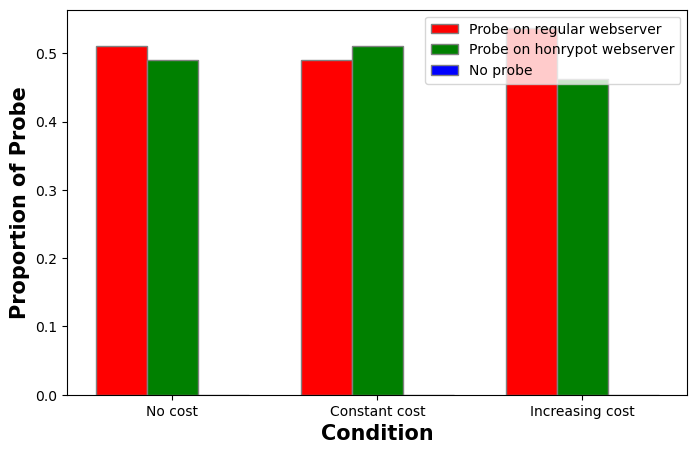

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# set width of bar
barWidth = 0.25
fig = plt.figure(figsize =(8, 5))

# set height of bar

cb = [0.51, 0.49, 0.537]
ucb = [0.49, 0.51, 0.463]
wa = [0.0, 0.0, 0.0]


# Set position of bar on X axis
br1 = np.arange(len(cb))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

# Make the plot
plt.bar(br1, cb, color ='r', width = barWidth, edgecolor ='grey', label ='Probe on regular webserver')
plt.bar(br2, ucb, color ='g', width = barWidth, edgecolor ='grey', label ='Probe on honrypot webserver')
plt.bar(br3, wa, color ='b', width = barWidth, edgecolor ='grey', label ='No probe')

# Adding Xticks
plt.xlabel('Condition', fontweight ='bold', fontsize = 15)
plt.ylabel('Proportion of Probe', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(cb))],['No cost', 'Constant cost', 'Increasing cost'])

plt.legend()
plt.show()


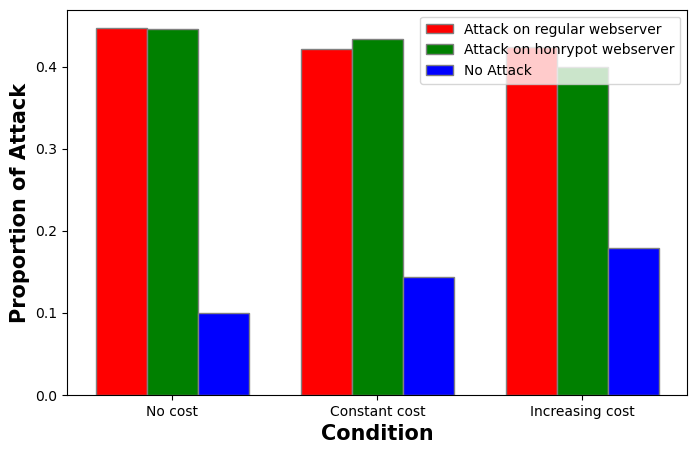

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# set width of bar
barWidth = 0.25
fig = plt.figure(figsize =(8, 5))

# set height of bar

cb = [0.447, 0.421, 0.424]
ucb = [0.446, 0.434, 0.40]
wa = [0.10, 0.144, 0.179]


# Set position of bar on X axis
br1 = np.arange(len(cb))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

# Make the plot
plt.bar(br1, cb, color ='r', width = barWidth, edgecolor ='grey', label ='Attack on regular webserver')
plt.bar(br2, ucb, color ='g', width = barWidth, edgecolor ='grey', label ='Attack on honrypot webserver')
plt.bar(br3, wa, color ='b', width = barWidth, edgecolor ='grey', label ='No Attack')

# Adding Xticks
plt.xlabel('Condition', fontweight ='bold', fontsize = 15)
plt.ylabel('Proportion of Attack', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(cb))],['No cost', 'Constant cost', 'Increasing cost'])

plt.legend()
plt.show()


## Comparison with Model and Human Data 

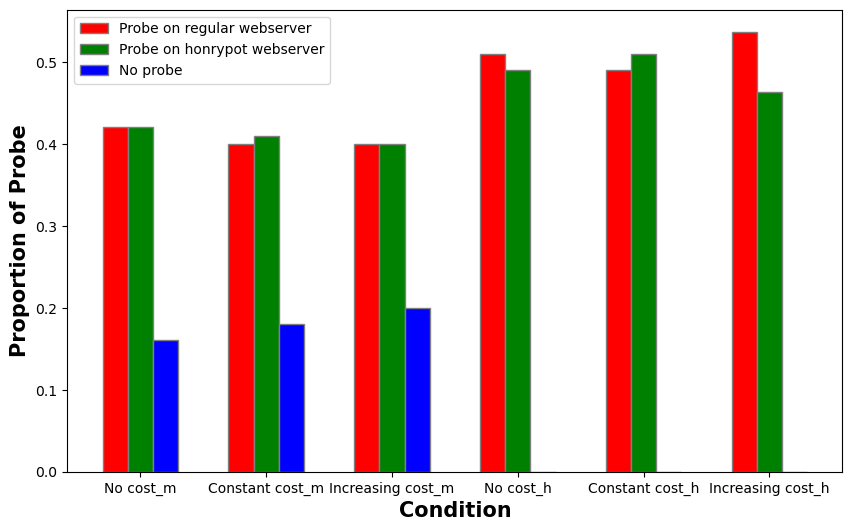

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# set width of bar
barWidth = 0.20
fig = plt.figure(figsize =(10, 6))

# set height of bar

cb = [0.42, 0.40, 0.40] + [0.51, 0.49, 0.537]
ucb = [0.42, 0.41, 0.40] + [0.49, 0.51, 0.463]
wa = [0.16, 0.18, 0.20] + [0.0, 0.0, 0.0]



# Set position of bar on X axis
br1 = np.arange(len(cb))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

# Make the plot
plt.bar(br1, cb, color ='r', width = barWidth, edgecolor ='grey', label ='Probe on regular webserver')
plt.bar(br2, ucb, color ='g', width = barWidth, edgecolor ='grey', label ='Probe on honrypot webserver')
plt.bar(br3, wa, color ='b', width = barWidth, edgecolor ='grey', label ='No probe')
# Adding Xticks
plt.xlabel('Condition', fontweight ='bold', fontsize = 15)
plt.ylabel('Proportion of Probe', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(cb))],['No cost_m', 'Constant cost_m', 'Increasing cost_m', 
                                                   'No cost_h','Constant cost_h', 'Increasing cost_h'])

plt.legend()
plt.show()


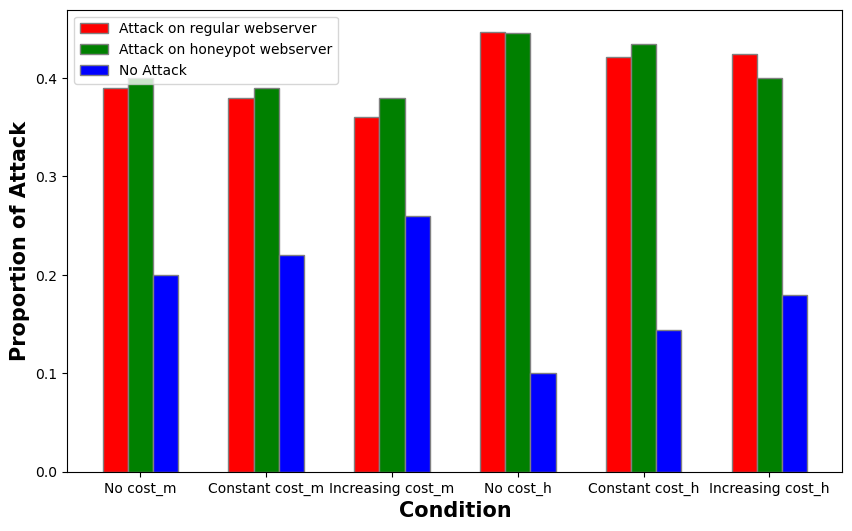

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# set width of bar
barWidth = 0.20
fig = plt.figure(figsize =(10, 6))

# set height of bar

cb = [0.39, 0.38, 0.36] + [0.447, 0.421, 0.424]
ucb = [0.40, 0.39, 0.38] + [0.446, 0.434, 0.40]
wa = [0.20, 0.22, 0.26] + [0.10, 0.144, 0.179]



# Set position of bar on X axis
br1 = np.arange(len(cb))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

# Make the plot
plt.bar(br1, cb, color ='r', width = barWidth, edgecolor ='grey', label ='Attack on regular webserver')
plt.bar(br2, ucb, color ='g', width = barWidth, edgecolor ='grey', label ='Attack on honeypot webserver')
plt.bar(br3, wa, color ='b', width = barWidth, edgecolor ='grey', label ='No Attack')
# Adding Xticks
plt.xlabel('Condition', fontweight ='bold', fontsize = 15)
plt.ylabel('Proportion of Attack', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(cb))],['No cost_m', 'Constant cost_m', 'Increasing cost_m', 
                                                   'No cost_h','Constant cost_h', 'Increasing cost_h'])

plt.legend()
plt.show()
